## This example implements a simple autoencoder, but very cool analysis.

## Taken from here: https://medium.com/@curiousily/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd

In [5]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

Using TensorFlow backend.


In [6]:
df = pd.read_csv("data/creditcard.csv")

In [7]:
df.shape

(284807, 31)

In [8]:
df.isnull().values.any()

False

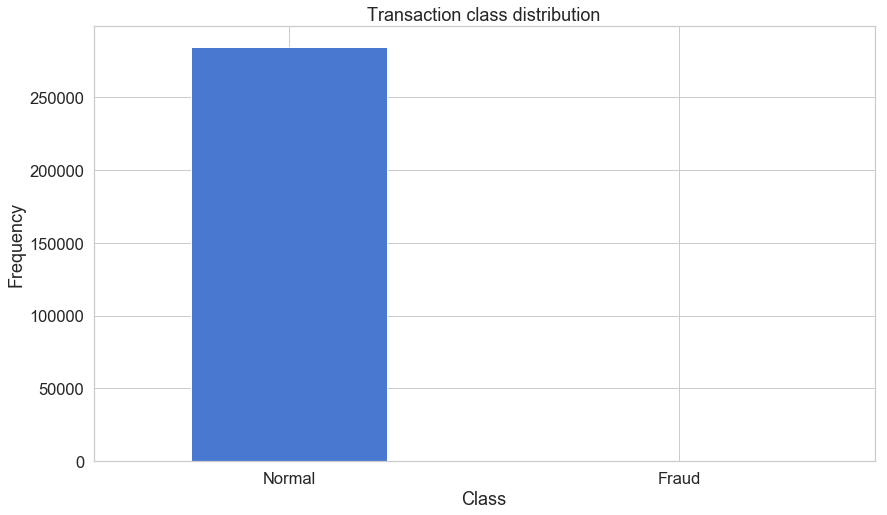

In [9]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [10]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]
frauds.shape

(492, 31)

In [12]:
normal.shape

(284315, 31)

In [13]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [14]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

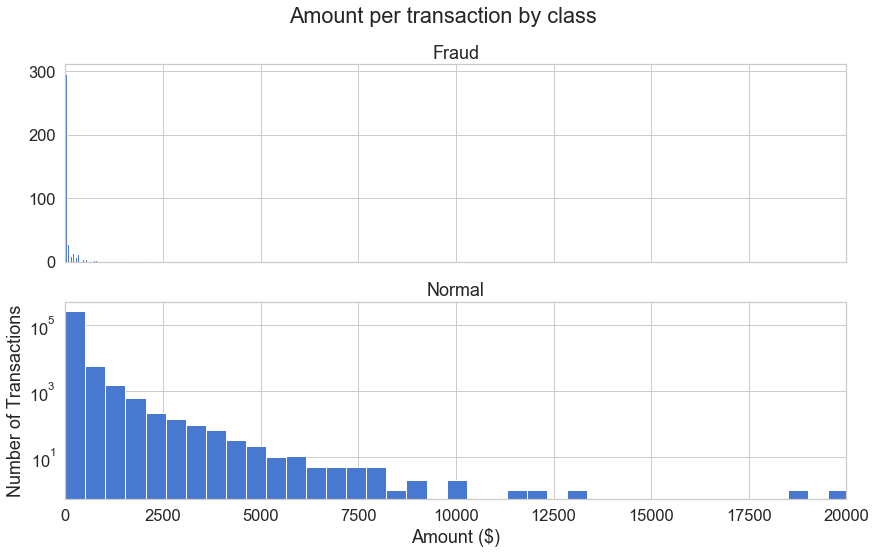

In [15]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

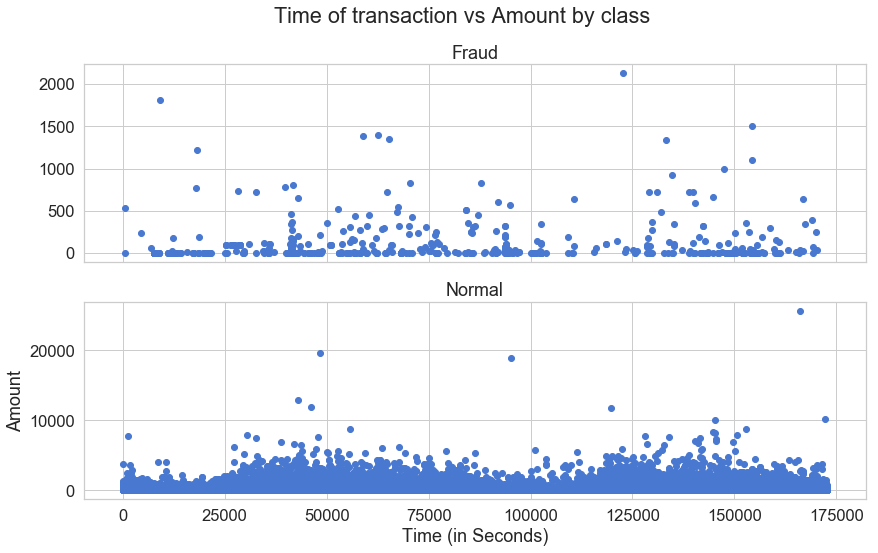

In [16]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [17]:
from sklearn.preprocessing import StandardScaler
data = df.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [19]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_train = X_train.values
X_test = X_test.values
X_train.shape

(227451, 29)

In [20]:
input_dim = X_train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

Instructions for updating:
Colocations handled automatically by placer.


In [21]:
nb_epoch = 100
batch_size = 32
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="models/model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Instructions for updating:
Use tf.cast instead.
Train on 227451 samples, validate on 56962 samples
Epoch 1/100
227451/227451 [==============================] - 8s 36us/step - loss: 0.8461 - acc: 0.4212 - val_loss: 0.8251 - val_acc: 0.4879
Epoch 2/100
227451/227451 [==============================] - 8s 36us/step - loss: 0.7858 - acc: 0.4945 - val_loss: 0.8081 - val_acc: 0.5096
Epoch 3/100
227451/227451 [==============================] - 8s 36us/step - loss: 0.7701 - acc: 0.5168 - val_loss: 0.7959 - val_acc: 0.5264
Epoch 4/100
227451/227451 [==============================] - 8s 37us/step - loss: 0.7605 - acc: 0.5242 - val_loss: 0.7873 - val_acc: 0.5299
Epoch 5/100
227451/227451 [==============================] - 8s 37us/step - loss: 0.7567 - acc: 0.5269 - val_loss: 0.7846 - val_acc: 0.5344
Epoch 6/100
227451/227451 [==============================] - 8s 36us/step - loss: 0.7548 - acc: 0.5283 - val_loss: 0.7839 - val_acc: 0.5268
Epoch 7/100
227451/227451 [==============================] - 

227451/227451 [==============================] - 9s 38us/step - loss: 0.7424 - acc: 0.5333 - val_loss: 0.7729 - val_acc: 0.5370
Epoch 57/100
227451/227451 [==============================] - 8s 36us/step - loss: 0.7425 - acc: 0.5339 - val_loss: 0.7730 - val_acc: 0.5407
Epoch 58/100
227451/227451 [==============================] - 9s 38us/step - loss: 0.7421 - acc: 0.5339 - val_loss: 0.7725 - val_acc: 0.5417
Epoch 59/100
227451/227451 [==============================] - 9s 37us/step - loss: 0.7422 - acc: 0.5341 - val_loss: 0.7794 - val_acc: 0.5213
Epoch 60/100
227451/227451 [==============================] - 9s 38us/step - loss: 0.7424 - acc: 0.5337 - val_loss: 0.7761 - val_acc: 0.5408
Epoch 61/100
227451/227451 [==============================] - 8s 37us/step - loss: 0.7421 - acc: 0.5336 - val_loss: 0.7800 - val_acc: 0.5350
Epoch 62/100
227451/227451 [==============================] - 8s 37us/step - loss: 0.7425 - acc: 0.5338 - val_loss: 0.7726 - val_acc: 0.5364
Epoch 63/100
227451/227451

In [22]:
autoencoder = load_model('models/model.h5')

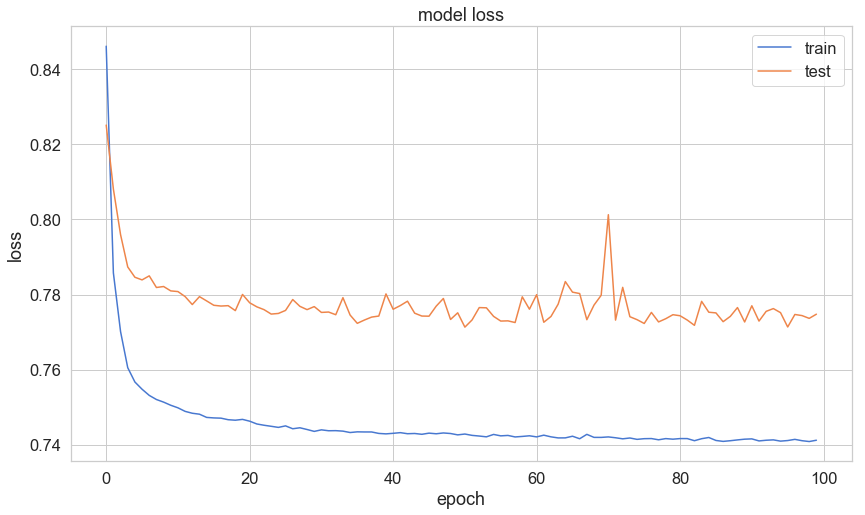

In [23]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [24]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.763642,0.001720
std,3.370856,0.041443
min,0.052144,0.000000
25%,0.284681,0.000000
50%,0.444766,0.000000
75%,0.660834,0.000000
max,271.979140,1.000000


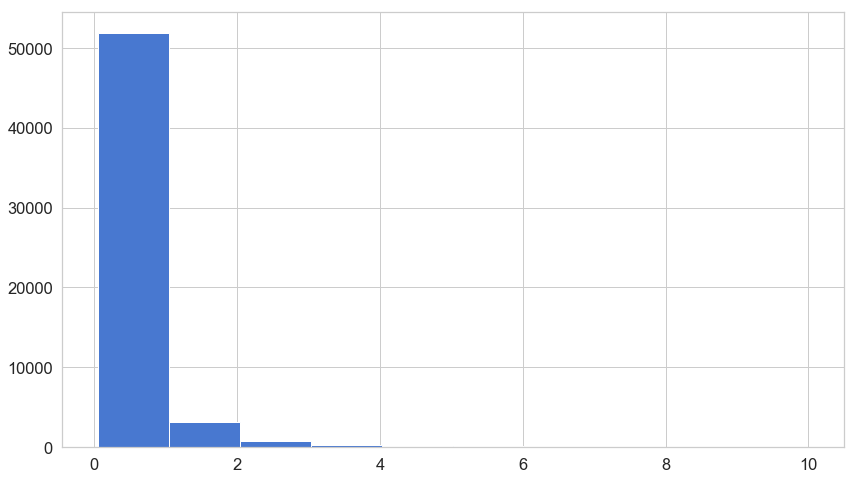

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

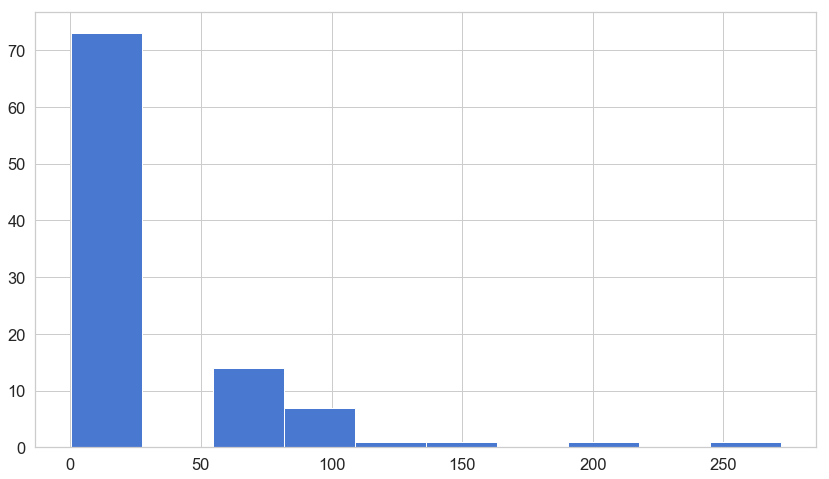

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [27]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

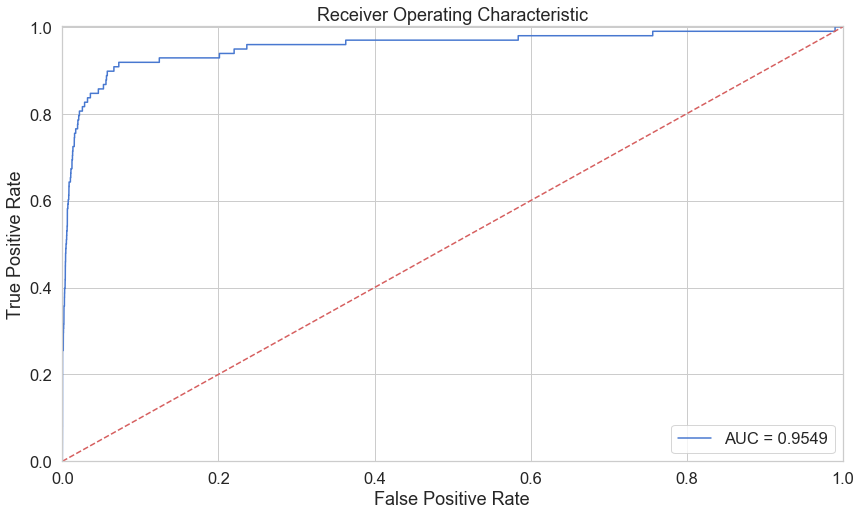

In [28]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

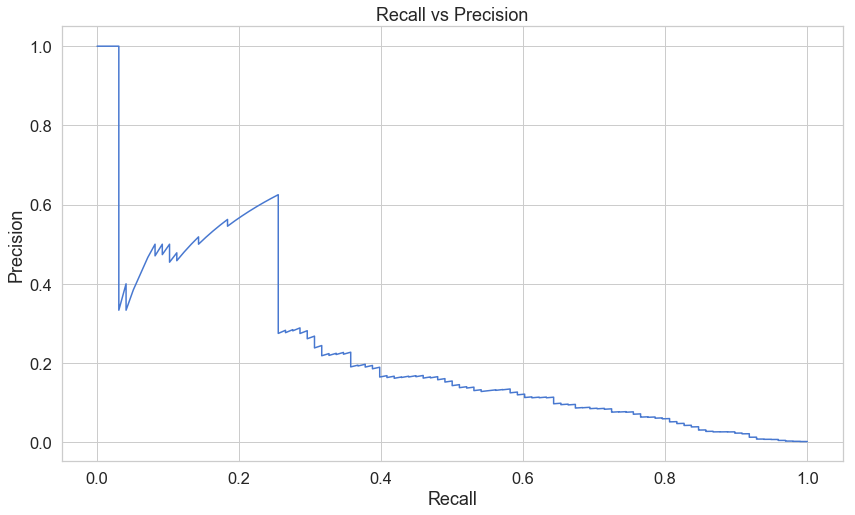

In [29]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

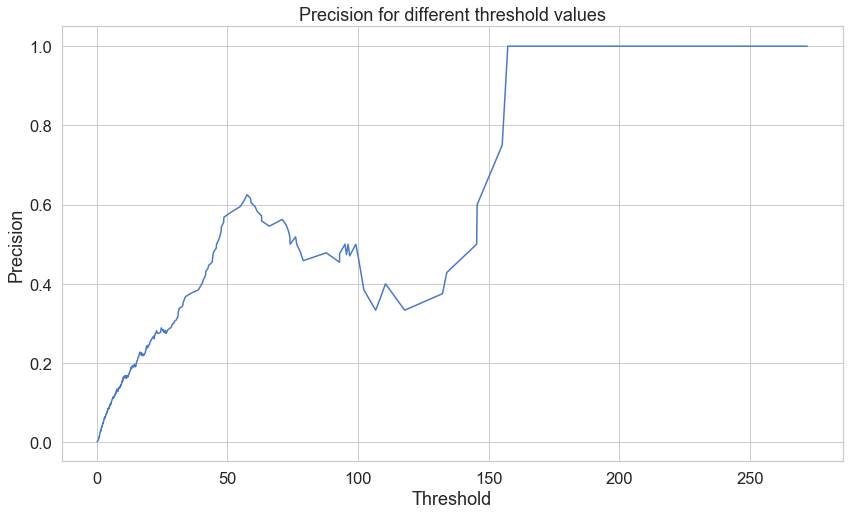

In [32]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

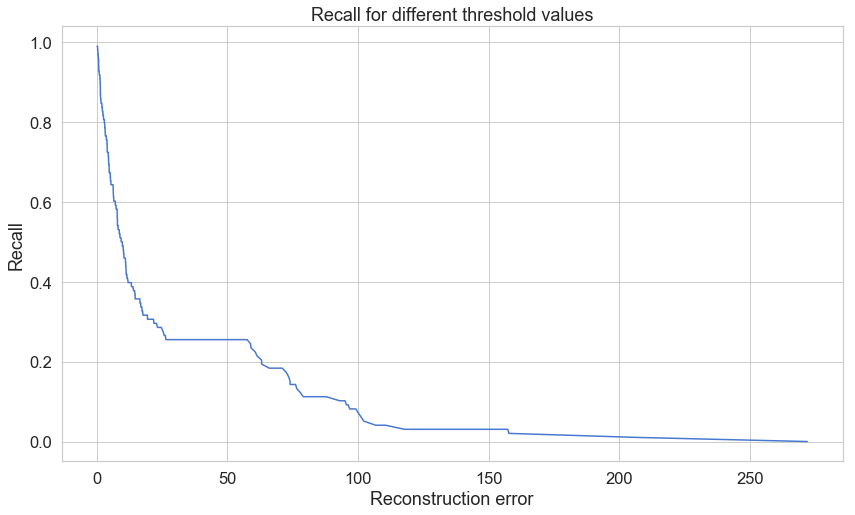

In [35]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

In [36]:
threshold = 2.9

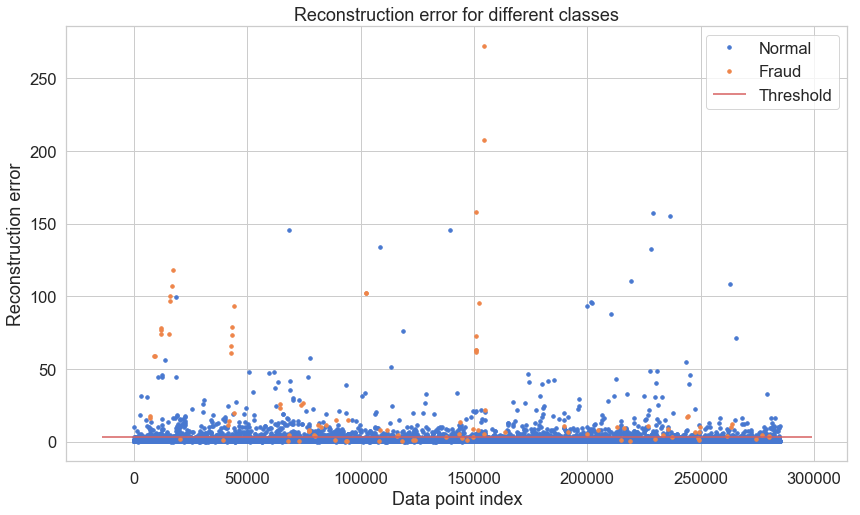

In [37]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

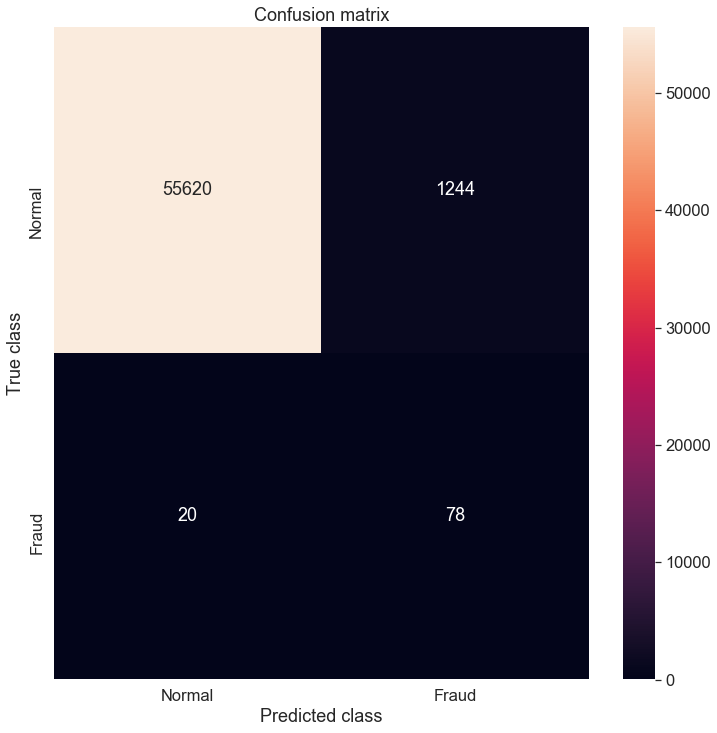

In [38]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()